# Imports

In [29]:
# handle math and data
import numpy as np
import pandas as pd
import time
import math

# to plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# handle files
import os
import sys
import joblib

# deep learning
import tensorflow as tf
from tensorflow import keras

# Example protobuf
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

# Setup

In [2]:
# random states
SEED = 69

K = keras.backend

def reset_backend():
    K.clear_session()
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# tf datasets directory
DATA_DIR = os.path.join(".", "_datasets", "12_tf_data")
os.makedirs(DATA_DIR, exist_ok=True)

# DEBUG mode (aka testing and experimenting)
DEBUG = True
AUTOTUNE = tf.data.AUTOTUNE

# Experiments

## Datasets and Shuffling

In [21]:
dataset_1 = tf.data.Dataset.range(100)
dataset_1

<RangeDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

In [36]:
def print_items_in_dataset(dataset):
    for item in dataset:
        print(item.numpy(), end="\n")

In [38]:
print_items_in_dataset(dataset_1.batch(10))

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]
[50 51 52 53 54 55 56 57 58 59]
[60 61 62 63 64 65 66 67 68 69]
[70 71 72 73 74 75 76 77 78 79]
[80 81 82 83 84 85 86 87 88 89]
[90 91 92 93 94 95 96 97 98 99]


In [42]:
dataset_1_shuff = dataset_1.shuffle(buffer_size=10, seed=SEED).batch(10)
print_items_in_dataset(dataset_1_shuff)

[ 4  9  7  8  3  6 14 10  1 18]
[ 5 17 19  2 11 15  0 21 26 12]
[22 16 23 13 28 33 25 35 36 31]
[37 32 39 29 41 27 24 46 43 34]
[49 40 51 20 52 44 53 54 48 57]
[50 42 30 38 60 45 56 64 47 68]
[55 65 61 70 58 71 75 63 67 73]
[78 66 79 59 76 82 77 84 74 85]
[69 88 62 81 86 90 93 83 92 89]
[72 95 87 99 80 91 98 94 97 96]


In [43]:
dataset_1_shuff = dataset_1.shuffle(buffer_size=100, seed=SEED).batch(10)
print_items_in_dataset(dataset_1_shuff)

[74 67 73 50 88 61 44 25 11 31]
[ 0 10 35 99 27 70 22 56 64  1]
[42 87 43 28 23 24 49 13 72 30]
[37 39  2 53 51 55 40 84 83 15]
[14 62 32  9 48 82 21 45 18 97]
[80 94 46 47 96 57 92 63  8 36]
[34 75 26 12 68 76 69 59 29 54]
[98  3 79 60 90 33 41 95 86 58]
[ 6 81  5 71 66 77 19 38 20 17]
[ 7 85 89 78 93 91 16  4 65 52]


So the batch is what gets random sampled into the returned dataset (the new shuffled dataset), and every time it gets random sampled, the next item in the original dataset will replace what was sampled.

>Ex. If batch size is 2 then 0 and 1 will be in batch. Then let's say 1 gets randomly sampled, then new batch will be 0 and 2 since 1 gets replaced by next item. Then this is repeated. 

>So a small batch size will return a new dataset that is only shuffled a little, since it's hard for 0 or 1 to just happen to not get sampled 90 times in a row, and it is impossible to sample let's say 99 in the beginning, since it is literally the last element.

>A batch size equal to size of dataset will basically just be normal shuffling since it will randomly sample from the batch, but the batch is literally the entire dataset.

## Interleaving Data

You shuffle and split the data file into many different files, and then you interleave and read from the files in a random order.

In [44]:
train_filepaths = os.path.join(".", "_datasets", "housing", "my_housing_*")

In [45]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=SEED)

In [54]:
for filepath in filepath_dataset.take(3):
    print(filepath)

tf.Tensor(b'./_datasets/housing/my_housing_ag', shape=(), dtype=string)
tf.Tensor(b'./_datasets/housing/my_housing_aj', shape=(), dtype=string)
tf.Tensor(b'./_datasets/housing/my_housing_af', shape=(), dtype=string)


In [83]:
n_readers = 5
bytestring_dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers,
    num_parallel_calls=tf.data.AUTOTUNE,
)

In [84]:
for line in bytestring_dataset.take(3):
    print(line.numpy())

b'-118.2,34.13,52.0,2035.0,459.0,2589.0,438.0,3.5349,193600.0,<1H OCEAN'
b'-121.79,36.95,34.0,2152.0,430.0,1516.0,386.0,3.7863,192200.0,<1H OCEAN'
b'-121.21,37.8,33.0,1862.0,429.0,971.0,389.0,2.6053,99200.0,INLAND'


## Parse and Prefetch

In [85]:
n_inputs = 8

def parse(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)] + ['']
    fields = tf.io.decode_csv(line, record_defaults=defs)
    # drop categorical
    fields = fields[:-1]
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return x, y

In [86]:
dataset = bytestring_dataset.map(parse, num_parallel_calls=tf.data.AUTOTUNE)

In [92]:
for tensor in dataset.take(1):
    print(tensor[0].numpy(), tensor[1].numpy())

[-117.89     34.09     35.     1205.      330.      583.      319.
    2.3971] [188900.]


In [100]:
dataset.batch(10).prefetch(1)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [99]:
dataset.batch(10)

<BatchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [96]:
dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=(8,), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>

In [97]:
bytestring_dataset

<ParallelInterleaveDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [98]:
filepath_dataset

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

So calling prefetch makes sense, because each dataset just wraps another one - so while you are training on one batch, another thread would read data from shuffled filepaths from disk, interleave the bytestrings, then map the parse function, then create another batch.
- Or maybe it's in reverse order: a batch would be determined, then that many lines are shuffled and interleaved and parsed

## Tensorflow Protobufs

Protobufs are ways to easily store structured data and serialize and parse the data. This way it allows data to be useful across all languages that can implement tensorflow.
>The `Example` protobuf is a chain of protobuf objects that ultimately allow you to store an instance with its feature names and feature values as a dictionary.

In [105]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(
                bytes_list=BytesList(
                    value=[b"Alice"]
                )
            ),
            "id": Feature(
                int64_list=Int64List(
                    value=[123]
                )
            ),
            "emails": Feature(
                bytes_list=BytesList(
                    value=[b"alice123@gmail.com",
                           b"alicecoolkid@icloud.com"]
                )
            )
        }
    )
)

In [118]:
serialized_person_example = person_example.SerializeToString()
serialized_person_example

b'\n[\n\x0b\n\x02id\x12\x05\x1a\x03\n\x01{\n\x11\n\x04name\x12\t\n\x07\n\x05Alice\n9\n\x06emails\x12/\n-\n\x12alice123@gmail.com\n\x17alicecoolkid@icloud.com'

Store the protobuf as a tfrecord.

In [119]:
example_protobuf_path = os.path.join(DATA_DIR, "test_example_protobuf.tfrecord")

with tf.io.TFRecordWriter(example_protobuf_path) as f:
    f.write(serialized_person_example)

## Load and Parse Example Protobuf

In [122]:
serialized_examples_dataset = tf.data.TFRecordDataset(example_protobuf_path)

for serialized_example in serialized_examples_dataset:
    print(serialized_example)

tf.Tensor(b'\n[\n\x0b\n\x02id\x12\x05\x1a\x03\n\x01{\n\x11\n\x04name\x12\t\n\x07\n\x05Alice\n9\n\x06emails\x12/\n-\n\x12alice123@gmail.com\n\x17alicecoolkid@icloud.com', shape=(), dtype=string)


To parse this, we need to create a description dictionary for the features in the protobuf.

In [128]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

for serialized_example in serialized_examples_dataset:
    parsed_example = tf.io.parse_single_example(serialized_example, 
                                                feature_description)

print(type(parsed_example))
parsed_example

<class 'dict'>


{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f9c88ecbfd0>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [125]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'alice123@gmail.com', b'alicecoolkid@icloud.com'], dtype=object)>

# Fashion MNIST using Data API

## Load Data

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train_full.shape

(60000, 28, 28)

In [20]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

X_train.shape

(55000, 28, 28)

In [21]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Visualize Images

In [25]:
def plot_image(image):
    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    plt.show()

## (Experimental) Save to tfrecord files

We need to first convert the numpy arrays to Example protobufs, then we can serialize the protobufs and write to tfrecord files.
- Convert numpy array to `Example` protobuf and serialize
    - Automate this with function
    - Apply to all feature data
- Write protobufs to tfrecord files
    - Each dataset (train, val, test) should be split into 20 files

### Convert Numpy Array to Protobuf

The Example protobuf should have 2 features:
- serialized image from the numpy array (BytesList)
- label of image (BytesList)

In [177]:
y_train[0]

4

In [179]:
serialized_image = b"bytestring of a serialized coat image matrix"
image_label = 4

fashion_image_example = Example(
    features=Features(
        feature={
            "image": Feature(
                bytes_list=BytesList(
                    value=[serialized_image]
                )
            ),
            "label": Feature(
                int64_list=Int64List(
                    value=[image_label]
                )
            )
        }
    )
)

In [180]:
fashion_image_example.features.feature["image"].bytes_list.value[0]

b'bytestring of a serialized coat image matrix'

In [181]:
numpy_coat = X_train[0]
tensor_coat = tf.convert_to_tensor(numpy_coat)

serialized_numpy_coat = tf.io.serialize_tensor(numpy_coat)
serialized_tensor_coat = tf.io.serialize_tensor(tensor_coat)

(serialized_numpy_coat == serialized_tensor_coat).numpy()

True

Numpy and tensors are often interchangeable, so we do not need to explicitly convert the numpy arrays into tensors to apply `tf.io.serialize_tensor()` in this case.

In [186]:
def convert_image_to_protobuf(X, y):
    X_protobufs = []
    
    for ix in range(X.shape[0]):
        image = X[ix]
        serialized_image = tf.io.serialize_tensor(image).numpy()
        label = y[ix]
        
        image_protobuf = Example(
            features=Features(
                feature={
                    "serialized_image": Feature(
                        bytes_list=BytesList(
                            value=[serialized_image]
                        )
                    ),
                    "label": Feature(
                        int64_list=Int64List(
                            value=[label]
                        )
                    )
                }
            )
        )
        
        X_protobufs.append(image_protobuf)
        
    return X_protobufs

In [225]:
train_protobufs = convert_image_to_protobuf(X_train, y_train)

len(train_protobufs)

55000

### Parse Serialized Image

In [226]:
serialized_coat = train_protobufs[0].features.feature["serialized_image"].bytes_list.value[0]
serialized_coat

b'\x08\x04\x12\x08\x12\x02\x08\x1c\x12\x02\x08\x1c"\x90\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00,\x7f\xb6\xb9\xa1x7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00*\xc6\xfb\xff\xfb\xf9\xf7\xff\xfc\xd6d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\xe9\xfc\xed\xef\xea\xed\xeb\xed\xed\xfe\xe3\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x10\xd2\xe1\xd7\xaf\xd9\xd8\xc1\xc4\xe2\xdd\xd12\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\xc7\xe5\xe8\xe6\xf5\xcc\xdb\xfd\xf5\xcf\xc2\xdf\xe7\xec\xeb\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x01\x00\x89\xeb\xcc\xd1\xc9\xd1\xea\xbe\xea\xda\xd7\xee\xef\xcc\xbd\xe0\x9a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc2\xc9\xc8\xd1\xca\xc1\xcd\xc2\xb7\xda\xe7\xc5\xac\xb5\xc1\xcd\xc7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\xd4\xcb\xbc\xbd\xc4\xc6\xc6\xc9\xc4\xd

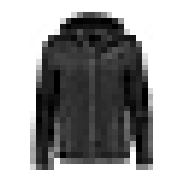

In [227]:
parsed_coat = tf.io.parse_tensor(serialized_coat, out_type=tf.uint8)
plot_image(parsed_coat)

In [228]:
train_protobufs[0].features.feature["label"].int64_list.value[0]

4

### Write to tfrecord files

Let's convert the val and test sets too.

In [229]:
val_protobufs = convert_image_to_protobuf(X_val, y_val)
test_protobufs = convert_image_to_protobuf(X_test, y_test)

We need to do the following:
- Get the indices of 20 equal sized lists
    - Do this for each of the train, val, test sets
- Create a list of filepaths for 20 tfrecord data files with suffix _00, _01, ... , _19, _20
    - Do this for each of the train, val, test sets
- Write the protobufs to each of the 20 files using the indices and filepaths
    - Do this for each of the train, val, test sets

**Get indices of split lists**

In [215]:
n_chunks = 20

val_indices = np.random.permutation(len(X_val))
val_indices.shape

(5000,)

In [216]:
val_indices = np.split(val_indices, n_chunks)

>**[numpy.split](https://numpy.org/doc/stable/reference/generated/numpy.split.html)**

**Get filepaths for each split**

In [218]:
FASHION_DATA_DIR = os.path.join(DATA_DIR, "my_fashion_mnist")
os.makedirs(FASHION_DATA_DIR, exist_ok=True)

In [223]:
val_filepaths = ["val_{:02d}.tfrecord".format(index)
                 for index in range(n_chunks)]

val_filepaths = [os.path.join(FASHION_DATA_DIR, filepath)
                 for filepath in val_filepaths]

val_filepaths

['./_datasets/12_tf_data/my_fashion_mnist/val_00.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnist/val_01.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnist/val_02.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnist/val_03.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnist/val_04.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnist/val_05.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnist/val_06.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnist/val_07.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnist/val_08.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnist/val_09.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnist/val_10.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnist/val_11.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnist/val_12.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnist/val_13.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnist/val_14.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnist/val_15.tfrecord',
 './_datasets/12_tf_data/my_fashion_mnis

**Write protobufs to filepaths**

In [224]:
val_indices[0]

array([3631,  811, 2824, 3313, 1343, 3545, 1832, 3252,  956,  978, 3224,
       4997, 2302, 1809, 2065,  950,   22,  947, 4945, 4586, 3891, 3715,
        309, 3413,  191, 2499, 4521, 4952,  499,  240, 1978, 4302,  274,
       1970, 2312, 3170, 1856, 3122, 2148, 3871,  848, 2294,  942, 1339,
       2568, 3820, 2842,  862, 4394, 4836,  545, 2834, 1513, 4298, 3212,
       2800, 2264, 1430, 4947,  542, 3251, 3546, 4808,  197, 2070, 1044,
       3346,  874, 4514, 3316,  803,  268, 2079, 4756, 4838,  130,  523,
       2089, 3661, 1315,   87, 2816, 4954, 1224, 4630, 1719, 2967,  169,
       1508, 3547, 2826, 4058, 3423, 1525,  453,  511, 2692, 4484, 1495,
       2999, 2108, 2782,   59, 1192,  789, 4294, 2779, 1614, 4639, 3646,
       2356, 2927, 4009, 2273,  172,  387, 2500,  368, 2112,  143, 2401,
        914, 3913, 1890,  450, 3865, 3105, 4286, 2565, 1896, 4706, 2138,
       4538,  263, 2137, 4901, 1750, 2581,  756, 3767, 4186, 4862, 4494,
       3716,   54, 3695,  960,  854,  123, 2704, 36

In [234]:
for chunk in range(n_chunks):
    val_ix = val_indices[chunk]
    val_fp = val_filepaths[chunk]
    
    with tf.io.TFRecordWriter(val_fp) as f:
        for ix in val_ix:
            f.write(val_protobufs[ix].SerializeToString())

### Load tfrecord as dataset

Load one of the split files and parse string to protobuf.

In [238]:
feature_description = {
    "serialized_image": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "label": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

serialized_val = tf.data.TFRecordDataset(val_filepaths[0])

for val_protobuf in serialized_val.take(1):
    parsed_val = tf.io.parse_single_example(val_protobuf, 
                                            feature_description)
    
type(parsed_val)

dict

In [240]:
parsed_val

{'label': <tf.Tensor: shape=(), dtype=int64, numpy=9>,
 'serialized_image': <tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x04\x12\x08\x12\x02\x08\x1c\x12\x02\x08\x1c"\x90\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x0094X3@\xaf\x8dgK93\'\'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x00r\xcb\xd1\xde{\x90\xd0\xcb\xd7\xdc\xe5\xbe\xf30\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x1d\x9d\xcb\xff\x9b\xc

## Save to tfrecord files

- Convert numpy arrays to Example protobufs
- Get indices and filepaths for n chunks
- Store each chunk as a tfrecord

### Helper Functions

In [26]:
def convert_image_to_example(image, label):
    image_data = tf.io.serialize_tensor(image)

    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }))

### save_as_tf_records

In [30]:
FILE_SAVE_DIR = os.path.join(".", "_datasets", "12_tf_data", "my_fashion_mnist")
os.makedirs(FILE_SAVE_DIR, exist_ok=True)

def write_tfrecords(name, dataset, n_chunks=10):
    paths = [os.path.join(FILE_SAVE_DIR, 
                          "{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_chunks))
             for index in range(n_chunks)]
    writers = [tf.io.TFRecordWriter(path)
               for path in paths]
    
    for index, (image, label) in dataset.enumerate():
        chunk = index % n_chunks
        example = convert_image_to_example(image, label)
        writers[chunk].write(example.SerializeToString())
    
    return paths

### Implementation

In [31]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

## Load tfrecords as datasets

Now that we have 20 tfrecords for train, val, and test sets, each file containing serialized image protobufs, let's load and interleave the files into dataset objects.
<br>
We need to do the following:
- Get all files corresponding to each set (train, val, test)
- Interleave the lines in each file
- Shuffle the dataset
- Preprocess each serialized protobuf
    - Create a feature description
    - Parse the serialized protobuf
    - Return a tuple containing a tensor of the image array and the label
        - Parse the serialized image tensor
- Batch the dataset
- Prefetch the dataset

In [32]:
DEBUG = False

if DEBUG:
    print("\n---------- DEBUGGING ----------\n")
    
    set_name = "val"
    
    # get filenames
    filenames = os.path.join(FILE_SAVE_DIR, set_name + "_*")
    filenames_dataset = tf.data.Dataset.list_files(filenames, shuffle=True, seed=SEED)
    print("\n --- Items in filenames_dataset --- \n")
    for item in filenames_dataset.take(3):
        print(item)
    
    # test to see if TFRecordDataset automatically interleaves when given num_parallel_reads > 1
    for filename in filenames_dataset.take(1):
        dataset = tf.data.TFRecordDataset(filename, num_parallel_reads=1)
    print("\n --- Items in dataset (non-interleaved) --- \n")
    for item in dataset.take(1):
        print(item)
        
    # parse serialized protobuf
    feature_description = {
        "serialized_image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    print("\n --- Parsed item in dataset (non-interleaved) --- \n")
    for item in dataset.take(1):
        parsed_item = tf.io.parse_single_example(item, feature_description)
        print(type(parsed_item), "\n", parsed_item)
    
    # parse tensor image
    print("\n --- Parsed item with parsed image tensor in dataset (non-interleaved) --- \n")
    parsed_item["serialized_image"] = tf.io.parse_tensor(parsed_item["serialized_image"],
                                                         out_type=tf.uint8)
    print(type(parsed_item), "\n", parsed_item)
    
    # method that does all the parsing
    def parse_image_protobuf(serialized_protobuf):
        feature_description = {
            "serialized_image": tf.io.FixedLenFeature([], tf.string, default_value=""),
            "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
        }
        parsed_dict = tf.io.parse_single_example(serialized_protobuf, feature_description)
        parsed_dict["serialized_image"] = tf.io.parse_tensor(parsed_dict["serialized_image"],
                                                             out_type=tf.uint8)
        return parsed_dict["serialized_image"], tf.cast(parsed_dict["label"], tf.uint8)
        
    # parsed tfrecord without interleave
    for filename in filenames_dataset.take(1):
        dataset = tf.data.TFRecordDataset(filename, num_parallel_reads=1)
    print("\n --- Parsed item in dataset (non-interleaved) --- \n")
    for item in dataset.take(1):
        image, label = parse_image_protobuf(item)
        print("Label: ", label)
        print("Image shape: ", image.shape)
        plot_image(image)
        
    # parsed tfrecord with interleave
    dataset = tf.data.TFRecordDataset(filenames_dataset, num_parallel_reads=AUTOTUNE)
    print("\n --- Parsed item in dataset (interleaved) --- \n")
    for item in dataset.take(1):
        image, label = parse_image_protobuf(item)
        print("Label: ", label)
        plot_image(image)
    
else:
    print("\n---------- NOT DEBUGGING ----------\n")
    
    # method that does all the parsing
    def preprocess(tfrecord):
        feature_descriptions = {
            "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
            "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
        }
        example = tf.io.parse_single_example(tfrecord, feature_descriptions)
        image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
        image = tf.reshape(image, shape=[28, 28])
        
        return image, example["label"]
    
    # method that returns optimized dataset object
    def fashion_mnist_dataset(filenames,
                              cache=True,
                              n_read_threads=AUTOTUNE, 
                              n_parse_threads=AUTOTUNE,
                              shuffle_buffer_size=None, 
                              batch_size=32):
        """ 
        Takes a set_name like "train" and creates and returns an optimized dataset 
        object that loads from tfrecord files in interleaved order, shuffles the dataset, 
        parses the serialized protobufs in the dataset, batches the dataset, 
        and prefetches the dataset.
        """
        
        # load serialized protobufs
        dataset = tf.data.TFRecordDataset(filenames, 
                                          num_parallel_reads=n_read_threads)
        
        # shuffle and repeat dataset
        if cache:
            dataset = dataset.cache()
        if shuffle_buffer_size:
            dataset = dataset.shuffle(shuffle_buffer_size)
        
        # parse dataset
        dataset = dataset.map(preprocess, 
                              num_parallel_calls=n_parse_threads)
        
        # batch and prefetch
        return dataset.batch(batch_size).prefetch(1)


---------- NOT DEBUGGING ----------



In [34]:
train_set = fashion_mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = fashion_mnist_dataset(valid_filepaths, shuffle_buffer_size=5000)
test_set = fashion_mnist_dataset(test_filepaths, shuffle_buffer_size=10000)

In [35]:
DEBUG = False

if DEBUG:
    print("\n---------- DEBUGGING ----------\n")
    
    sample_dataset = test_dataset
    sample_set = X_test
    
    for batch in sample_dataset.take(1):
        sample_batch = batch
    
    # Batch is a tuple containing (X, y)
    # where X and y are values for 32 individual samples
    print("\n--- First image input in dataset ---\n")
    print(attribute_names[sample_batch[1][0].numpy()])
    plot_image(sample_batch[0][0])
    
    # Make sure the efficient dataset contains all items
    print("\n--- Compare number of batches (should be equal) ---\n")
    batch_size = 32
    print(len(sample_set) / batch_size)
    i = 0
    for batch in sample_dataset:
        i += 1
    print(i)
    
else:
    print("\n---------- NOT DEBUGGING ----------\n")
    


---------- NOT DEBUGGING ----------



## Train model on datasets

So now that we have efficient dataset objects that will load, interleave, shuffle, parse, batch, and prefetch the data, let's train our model.
<br>

We need to do the following:
- Create a preprocessing layer that standardizes inputs
- Create our sequential classification model
- Find optimal learning rate
- Create callbacks
- Train

### Create Model

In [37]:
DEBUG = False

if DEBUG:
    print("\n---------- DEBUGGING ----------\n")
    
    
    # Adapt and Input data processing
    
    n_batches = 10
    batch_size = 32
    adapt_shape = [n_batches * batch_size, 28, 28]
    adapt_dataset = train_dataset
    
    adapt_data = tf.stack([batch[0] for batch in adapt_dataset.take(n_batches)])
    adapt_data = tf.reshape(adapt_data, adapt_shape)
    print("\n--- Adapt data shape ---\n")
    print(adapt_data.shape)
    
    input_data = tf.stack([batch[0][0] for batch in val_dataset.take(1)])
    print("\n--- Input data shape ---\n")
    print(input_data.shape)
    
    
    # Normalization Layer
    
    std_layer = keras.layers.Normalization(axis=(-2,-1))
    std_layer.adapt(adapt_data)

    scaled_image = std_layer(input_data)
    print("\n--- Scaled input data ---\n")
    print(scaled_image.shape)
    plot_image(scaled_image[0])
    
    
    # Flatten Layer
    
    input_layer = keras.layers.Flatten(input_shape=[28, 28])
    
    
    # Unbatch adapt and input data
    
    n_samples = 1000
    adapt_dataset = train_dataset
    
    adapt_data = tf.stack([sample[0] for sample in adapt_dataset.unbatch().take(n_samples)])
    print("\n--- Unbatched Adapt data shape ---\n")
    print(adapt_data.shape)
    
    input_data = tf.stack([sample[0] for sample in val_dataset.unbatch().take(1)])
    print("\n--- Unbatched Input data shape ---\n")
    print(input_data.shape)
    
    
    # Flatten adapt and input data
    
    flattened_adapt_data = input_layer(adapt_data)
    print("\n--- Flattened Adapt data shape ---\n")
    print(flattened_adapt_data.shape)

    flattened_input_data = input_layer(input_data)
    print("\n--- Flattened Input data shape ---\n")
    print(flattened_input_data.shape)
    
    
    # Normalization layer on flattened data
    
    std_layer = keras.layers.Normalization(axis=-1)
    std_layer.adapt(flattened_adapt_data)
    scaled_input = std_layer(flattened_input_data)
    
    print("\n--- Scaled Flattened Input data shape ---\n")
    print(scaled_input.shape)
    plot_image(tf.reshape(scaled_input, [28, 28]))
    
    
else:
    print("\n---------- NOT DEBUGGING ----------\n")
    
    
    def create_fashion_model(adapt_dataset, 
                             n_hidden=3, n_neurons=300, 
                             n_adapt_samples=1000):
        reset_backend()

        # Create model
        model = keras.Sequential()

        # Flatten Layer
        input_layer = keras.layers.Flatten(input_shape=[28, 28])
        model.add(input_layer)

        # Normalization Layer
        adapt_data = tf.stack([sample[0] for sample in adapt_dataset.unbatch().take(n_adapt_samples)])
        flattened_adapt_data = input_layer(adapt_data)

        std_layer = keras.layers.Normalization(axis=-1)
        std_layer.adapt(flattened_adapt_data)
        model.add(std_layer)

        # Hidden Layers
        for _ in range(n_hidden):
            model.add(keras.layers.Dense(n_neurons, 
                                         activation="elu", 
                                         kernel_initializer="he_normal"))

        # Output Layer
        model.add(keras.layers.Dense(10, activation="softmax"))
        return model
    
    model = create_fashion_model(train_set)
    model.summary()


---------- NOT DEBUGGING ----------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 normalization (Normalizatio  (None, 784)              1569      
 n)                                                              
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dense_2 (Dense)             (None, 300)               90300     
                                                                 
 dense_3 (Dense)             (None, 10)                3010      
                  

In [350]:
# compile model
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

### LR Helper Functions

In [351]:
def round_up_to_tenth(n):
    a = np.log(n) / np.log(10)
    a_ = np.rint(a)
    return 10**a_

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-10, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses, max_loss=None):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    
    tick = round_up_to_tenth(min(rates))
    x_ticks = []
    while tick < max(rates)*10:
        x_ticks.append(tick)
        tick = tick * 10
    plt.gca().set_xticks(x_ticks)
    
    plt.hlines(min(losses), min(rates), max(rates))
    if max_loss is None:
        plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    else:
        plt.axis([min(rates), max(rates), min(losses), max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

### Find Optimal LR

In [352]:
epochs = 1
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train,
                                   epochs=epochs, batch_size=batch_size,
                                   min_rate=1e-8, max_rate=10)

430/430 [==============================] - 4s 6ms/step - loss: 1183.1133 - accuracy: 0.2639


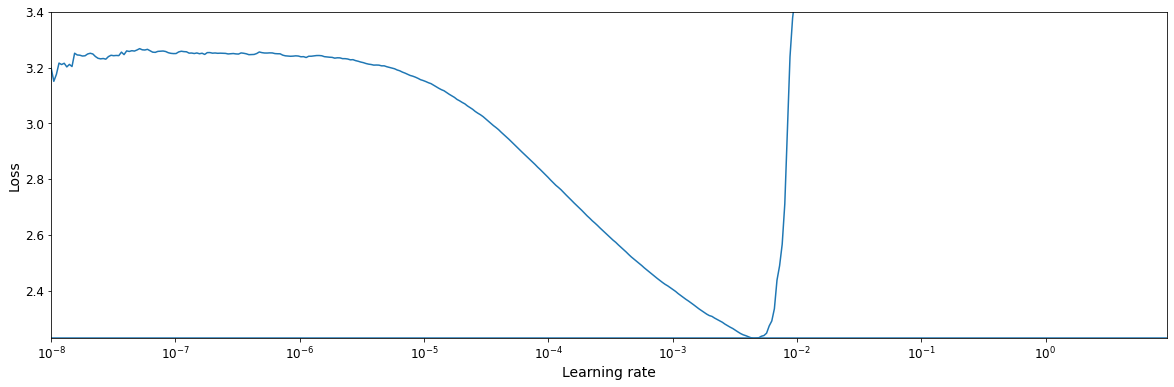

In [358]:
plt.figure(figsize=(20,6))
plot_lr_vs_loss(rates, losses, max_loss=3.4)

Let's go with `5e-4`

### Train Model

In [39]:
TRAIN = True

if TRAIN:
    print("\n---------- TRAINING ----------\n")
    
    
    model_id = "first_model"
    LOG_DIR = os.path.join(".", "_tf_logs", "12_tf_data")
    os.makedirs(LOG_DIR, exist_ok=True)

    # Tensorboard
    run_index = 3
    run_logdir = os.path.join(LOG_DIR, model_id + "_run_{:02d}".format(run_index))
    tensorboard_cb = keras.callbacks.TensorBoard(
        log_dir=run_logdir,  histogram_freq=1, profile_batch=10)
    print("\n--- TensorBoard Directory: {} ---\n".format(run_logdir))

    # All callbacks
    callbacks = [tensorboard_cb]
    
    
    # Train Model
    
    model = create_fashion_model(train_set)

    optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

    history = model.fit(train_set, epochs=10, 
                        validation_data=valid_set,
                        callbacks=callbacks)
else:
    print("\n---------- LOADING SAVED MODEL ----------\n")


---------- TRAINING ----------


--- TensorBoard Directory: ./_tf_logs/12_tf_data/first_model_run_03 ---



2022-07-04 11:50:13.912999: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-07-04 11:50:13.913028: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-07-04 11:50:13.913220: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.


Epoch 1/10
     39/Unknown - 1s 6ms/step - loss: 7189.3735 - accuracy: 0.6731

2022-07-04 11:50:15.216706: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-07-04 11:50:15.216723: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-07-04 11:50:15.222550: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-04 11:50:15.225455: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-07-04 11:50:15.230433: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./_tf_logs/12_tf_data/first_model_run_03/plugins/profile/2022_07_04_11_50_15

2022-07-04 11:50:15.232827: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./_tf_logs/12_tf_data/first_model_run_03/plugins/profile/2022_07_04_11_50_15/evilonna-C.local.trace.json.gz
2022-07-04 11:50:15.238399: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./_tf_logs/12_

1719/1719 [==============================] - 11s 6ms/step - loss: 446.2132 - accuracy: 0.8398 - val_loss: 2039.4036 - val_accuracy: 0.8734
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 831.1343 - accuracy: 0.8842 - val_loss: 249.6432 - val_accuracy: 0.8812
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 913.2344 - accuracy: 0.9004 - val_loss: 91.7301 - val_accuracy: 0.8806
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 51.7051 - accuracy: 0.9121 - val_loss: 589.5067 - val_accuracy: 0.8900
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 62.5098 - accuracy: 0.9219 - val_loss: 377.7085 - val_accuracy: 0.8932
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 174.0726 - accuracy: 0.9305 - val_loss: 242.0870 - val_accuracy: 0.8908
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 140.6279 - accuracy: 0.9393 - val_loss: 52.8440

In [361]:
# tensorboard --logdir=./_tf_logs/12_tf_data --port=6006

### Evaluate

In [41]:
model.evaluate(test_set)

313/313 [==============================] - 1s 2ms/step - loss: 39.6910 - accuracy: 0.8773


[39.69100570678711, 0.8773000240325928]

# IMDB Reviews

## Get Data

In [72]:
import tarfile

AUTO = tf.data.AUTOTUNE

EXTRACTED = True
IMDB_PATH = os.path.join(".", "_datasets", "imdb_reviews")

def extract_imdb(imdb_path=IMDB_PATH):
    tgz_path = os.path.join(imdb_path, "aclImdb_v1.tar.gz")
    
    imdb_tgz = tarfile.open(tgz_path)
    imdb_tgz.extractall(path=imdb_path)
    imdb_tgz.close()
    
if not EXTRACTED:
    print("\n---------- EXTRACTING DATA ----------\n")
    
    extract_imdb()
else:
    print("\n---------- ALREADY EXTRACTED ----------\n")
    


---------- ALREADY EXTRACTED ----------



From the README:
>Within these
directories, reviews are stored in text files named following the
convention [[id]_[rating].txt] where [id] is a unique id and [rating] is
the star rating for that review on a 1-10 scale. For example, the file
[test/pos/200_8.txt] is the text for a positive-labeled test set
example with unique id 200 and star rating 8/10 from IMDb.

In [213]:
! rm -rf ./_datasets/imdb_reviews/aclImdb/train/pos/.ipynb_checkpoints

### Split Train, Valid, Test

In [214]:
DEBUG = False

if DEBUG:
    print("\n---------- DEBUGGING ----------\n")

    TRAIN_POS_DATA_DIR = os.path.join(".", "_datasets", "imdb_reviews", "aclImdb", "train", "pos")
    TRAIN_POS_FILENAMES = os.listdir(TRAIN_POS_DATA_DIR)

    print("\n--- Train set positive reviews filenames ---\n")
    print("Num files: ", len(TRAIN_POS_FILENAMES))
    for filename in TRAIN_POS_FILENAMES[:10]:
        print(filename)
    print("\n...\n")
    for filename in TRAIN_POS_FILENAMES[-10:]:
        print(filename)

    TRAIN_NEG_DATA_DIR = os.path.join(".", "_datasets", "imdb_reviews", "aclImdb", "train", "neg")
    TRAIN_NEG_FILENAMES = os.listdir(TRAIN_NEG_DATA_DIR)

    print("\n--- Train set negative reviews filenames ---\n")
    print("Num files: ", len(TRAIN_NEG_FILENAMES))
    for filename in TRAIN_NEG_FILENAMES[:10]:
        print(filename)
    print("\n...\n")
    for filename in TRAIN_NEG_FILENAMES[-10:]:
        print(filename)
        
    print("\n--- Examination of a txt file in Train Pos ---\n")
    rand_index = np.random.randint(len(TRAIN_POS_FILENAMES)-1)
    sample_filename = TRAIN_POS_FILENAMES[rand_index]
    sample_filepath = os.path.join(TRAIN_POS_DATA_DIR, sample_filename)
    sample_file = tf.io.read_file(sample_filepath)
    print("Filename: {}\n".format(sample_filename))
    print("File: {}\n".format(sample_file))
    
    print("\n--- Read the entire txt as one element in dataset ---\n")
    dataset = tf.data.TextLineDataset(sample_filepath)
    for item in dataset:
        print(item)
        
else:
    print("\n---------- NOT DEBUGGING ----------\n")
    
    
    # Get all filepaths for train pos/neg, val pos/neg, and test pos/neg
    
    def return_filepaths(directory):
        return [os.path.join(directory, filename)
                for filename in os.listdir(directory)]
    
    TRAIN_DIR = os.path.join(".", "_datasets", "imdb_reviews", "aclImdb", "train")
    train_pos_filepaths = return_filepaths(os.path.join(TRAIN_DIR, "pos"))
    train_neg_filepaths = return_filepaths(os.path.join(TRAIN_DIR, "neg"))
    
    TEST_DIR = os.path.join(".", "_datasets", "imdb_reviews", "aclImdb", "test")
    test_pos_filepaths = return_filepaths(os.path.join(TEST_DIR, "pos"))
    test_neg_filepaths = return_filepaths(os.path.join(TEST_DIR, "neg"))
    valid_pos_filepaths = test_pos_filepaths[:7500]
    valid_neg_filepaths = test_neg_filepaths[:7500]
    test_pos_filepaths = test_pos_filepaths[7500:]
    test_neg_filepaths = test_neg_filepaths[7500:]
    
    print("\n--- Train, Valid, and Test Filepaths ---\n")
    print("Train: ", len(train_pos_filepaths), len(train_neg_filepaths))
    print("Valid: ", len(valid_pos_filepaths), len(valid_neg_filepaths))
    print("Test: ", len(test_pos_filepaths), len(test_neg_filepaths))


---------- NOT DEBUGGING ----------


--- Train, Valid, and Test Filepaths ---

Train:  12500 12500
Valid:  7500 7500
Test:  5000 5000


### Create Efficient Datasets

- Create a list of ones and zeros for pos and neg filepaths
- Create dataset from filepaths and labels
- Shuffle dataset
- Read each file in the dataset
- Batch and prefetch

In [262]:
DEBUG = False

if DEBUG:
    print("\n---------- DEBUGGING ----------\n")
    
    
    print("\n--- Train Set Filepaths with Labels ---\n")
    train_pos_labels = np.ones(len(train_pos_filepaths))
    train_neg_labels = np.zeros(len(train_neg_filepaths))
    
    train_labels = np.r_[train_pos_labels, train_neg_labels]
    train_filepaths = train_pos_filepaths + train_neg_filepaths
    
    train_set = tf.data.Dataset.from_tensor_slices((train_filepaths, tf.cast(train_labels, tf.uint8)))
    
    for filepath, label in train_set.take(3):
        print("Filepath: ", filepath)
        print("Label: ", label)
    
    print("\n--- Train Set File Text with Labels ---\n")
    train_set = train_set.shuffle(len(train_set))
    
    def preprocess(filepath, label):
        return tf.io.read_file(filepath), label
    
    train_set = train_set.map(preprocess,
                              num_parallel_calls=AUTO)
    for filepath, label in train_set.take(1):
        print("File: ", filepath)
        print("Label: ", label)
    
else:
    print("\n---------- NOT DEBUGGING ----------\n")
    
    
    def preprocess(filepath, label):
        return tf.io.read_file(filepath), label
    
    def imdb_dataset(pos_filepaths, neg_filepaths):
        labels = np.r_[np.ones(len(pos_filepaths)), 
                       np.zeros(len(neg_filepaths))]
        dataset = tf.data.Dataset.from_tensor_slices(
            (tf.constant(pos_filepaths + neg_filepaths),
             tf.cast(labels, tf.uint8))
        )
        dataset = dataset.shuffle(len(train_set))
        dataset = dataset.map(preprocess,
                              num_parallel_calls=AUTO)
        return dataset.batch(32).prefetch(1)
    
    train_set = imdb_dataset(train_pos_filepaths, train_neg_filepaths)
    valid_set = imdb_dataset(valid_pos_filepaths, valid_neg_filepaths)
    test_set = imdb_dataset(test_pos_filepaths, test_neg_filepaths)


---------- NOT DEBUGGING ----------



### Binary Classifier

- Create a text vectorization layer
- Create an embedding layer
- Create model with sigmoid activation for output
- Train and evaluate model

#### TextVectorization Experiments

What does tf.keras.layers.TextVectorization do?
>A preprocessing layer which maps text features to integer sequences.

The processing of each example contains the following steps:
- Standardize each example (usually lowercasing + punctuation stripping)
- Split each example into substrings (usually words)
- Recombine substrings into tokens (usually ngrams)
- Index tokens (associate a unique int value with each token)
- Transform each example using this index, either into a vector of ints or a dense float vector.


In [268]:
sample_text = next(iter(train_set.unbatch().take(1)))[0]
sample_text

<tf.Tensor: shape=(), dtype=string, numpy=b'It is a rare occasion when I want to see a movie again. "The Amati Girls" is such a movie. In old time movie theaters I would have stayed put for more showings. Was this story autobiographical for the writer/director? It has the aura of reality.<br /><br />The all star cast present their characters believably and with tenderness. Who would not want Mercedes Ruehl as an older sister? I have loved her work since "For Roseanna".<br /><br />With most movies, one suspends belief because we know that it is the work of actors, producers, directors, sound technicians, etc. It was hard to suspend such belief in "The Amati Girls". One feels such a part of this family! How I wanted to come to the defense of Dolores when her family is stifling her emotional life. And wanted to cheer Lee Grant as she levels criticism at Cloris Leachman\'s hair color. The humor throughout is not belly laugh humor, but instead has a feel-good quality that satisfies far more

In [302]:
debug_text = b"This movie was so great!<br /><br />I love \"Finding Nemo\" so much!!!"
debug_text

b'This movie was so great!<br /><br />I love "Finding Nemo" so much!!!'

In [303]:
text_vec_layer = tf.keras.layers.TextVectorization(
    max_tokens=1000,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=50,
)

text_vec_layer.adapt([debug_text])

In [304]:
text_vec_layer([debug_text])

<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[ 4,  7,  3,  2, 10, 12,  9,  8, 11,  5,  2,  6,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]])>

The string has been mapped to a vector of size 50, and each word has been indexed.

In [305]:
text_vec_layer.get_vocabulary()

['',
 '[UNK]',
 'so',
 'was',
 'this',
 'nemo',
 'much',
 'movie',
 'love',
 'i',
 'greatbr',
 'finding',
 'br']

We need to do our own preprocessing before using keras' TextVectorization layer.

In [306]:
def preprocess_imdb_text(text):
    Z = tf.strings.substr(text, 0, 300)
    Z = tf.strings.lower(Z)
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    return [Z.numpy()]

In [307]:
preprocess_imdb_text(debug_text)

[b'this movie was so great   i love  finding nemo  so much   ']

In [308]:
text_vec_layer = tf.keras.layers.TextVectorization(
    max_tokens=1000,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=50,
)

text_vec_layer.adapt(preprocess_imdb_text(debug_text))

In [309]:
text_vec_layer(preprocess_imdb_text(debug_text))

<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[ 4,  7,  3,  2, 10,  9,  8, 11,  5,  2,  6,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]])>

In [310]:
text_vec_layer.get_vocabulary()

['',
 '[UNK]',
 'so',
 'was',
 'this',
 'nemo',
 'much',
 'movie',
 'love',
 'i',
 'great',
 'finding']

Let's try adapting to a real sample.

In [311]:
text_vec_layer.reset_state()

In [312]:
text_vec_layer.adapt(preprocess_imdb_text(sample_text))

In [313]:
text_vec_layer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'movie',
 'a',
 'it',
 'is',
 'i',
 'for',
 'writer',
 'would',
 'when',
 'was',
 'want',
 'to',
 'time',
 'this',
 'their',
 'theaters',
 'such',
 'story',
 'stayed',
 'star',
 'showings',
 'see',
 'reality',
 'rare',
 'put',
 'present',
 'old',
 'of',
 'occasion',
 'more',
 'in',
 'have',
 'has',
 'girls',
 'director',
 'characters',
 'cast',
 'autobiographical',
 'aura',
 'amati',
 'all',
 'again']

In [314]:
text_vec_layer(preprocess_imdb_text(sample_text))

<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[ 5,  6,  4, 26, 31, 11,  7, 13, 14, 24,  4,  3, 44,  2, 42, 36,
         6, 19,  4,  3, 33, 29, 15,  3, 18,  7, 10, 34, 21, 27,  8, 32,
        23, 12, 16, 20, 40,  8,  2,  9, 37,  5, 35,  2, 41, 30, 25,  2,
        43, 22]])>

Let's try making the text preprocessing into a custom layer.

In [322]:
def preprocess_imdb(X_batch):
    Z = tf.strings.lower(X_batch)
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    return Z

class TextPreprocess(keras.layers.Layer):
    def __init__(self, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
    def __call__(self, inputs):
        return preprocess_imdb(inputs)
    
text_preprocess_layer = TextPreprocess()

text_vec_layer = tf.keras.layers.TextVectorization(
    max_tokens=1000,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=50,
)

sample_review_batches = train_set.map(lambda review, label: review)

text_vec_layer.adapt(sample_review_batches.take(100))

model = keras.Sequential([
    text_preprocess_layer,
    text_vec_layer,
])

In [331]:
model.predict(train_set.take(1))

1/1 [==============================] - 0s 86ms/step


array([[  1,  17,   4, ...,   1,  52,  17],
       [ 10, 292,  11, ...,   6, 270, 340],
       [  1,   7,   6, ...,   5, 186, 257],
       ...,
       [ 33,   1, 325, ...,   1,   3,  42],
       [  1, 140,   7, ...,  32, 882,   1],
       [  2,   1,   7, ...,   2, 193,   1]])

In [ ]:
model.get_layer("text_vectorization_5").get_vocabulary()

#### Bag of Words Experiments

Now let's implement a custom bag of words class.

In [339]:
simple_example = tf.constant([[1, 3, 1, 0, 0], [2, 2, 0, 0, 0]])
tf.one_hot(simple_example, 4)

<tf.Tensor: shape=(2, 5, 4), dtype=float32, numpy=
array([[[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]]], dtype=float32)>

In [344]:
tf.reduce_sum(tf.one_hot(simple_example, 2), axis=1)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 2.],
       [3., 0.]], dtype=float32)>

In [343]:
tf.reduce_sum(tf.one_hot(simple_example, 5), axis=1)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[2., 2., 0., 1., 0.],
       [3., 0., 2., 0., 0.]], dtype=float32)>

In [345]:
class BagOfWords(keras.layers.Layer):
    def __init__(self, n_tokens, dtype=tf.int32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.n_tokens = n_tokens
    def call(self, inputs):
        one_hot = tf.one_hot(inputs, self.n_tokens)
        return tf.reduce_sum(one_hot, axis=1)[:, 1:]

In [347]:
bow_layer = BagOfWords(n_tokens=50)

model = keras.Sequential([
    text_preprocess_layer,
    text_vec_layer,
    bow_layer,
])

model.predict(train_set.take(1))

1/1 [==============================] - 0s 120ms/step


array([[15.,  2.,  1., ...,  0.,  0.,  0.],
       [21.,  4.,  2., ...,  0.,  0.,  0.],
       [14.,  3.,  2., ...,  0.,  0.,  0.],
       ...,
       [ 7.,  2.,  0., ...,  0.,  1.,  0.],
       [ 8.,  2.,  1., ...,  0.,  0.,  0.],
       [11.,  4.,  1., ...,  0.,  0.,  0.]], dtype=float32)

#### Model

Classes for text preprocessing and bag of words.

In [348]:
def preprocess_imdb(X_batch):
    Z = tf.strings.lower(X_batch)
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    return Z

class TextPreprocess(keras.layers.Layer):
    def __init__(self, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
    def __call__(self, inputs):
        return preprocess_imdb(inputs)
    
class BagOfWords(keras.layers.Layer):
    def __init__(self, n_tokens, dtype=tf.int32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.n_tokens = n_tokens
    def call(self, inputs):
        one_hot = tf.one_hot(inputs, self.n_tokens)
        return tf.reduce_sum(one_hot, axis=1)[:, 1:]

In [356]:
reset_backend()

text_preprocess_layer = TextPreprocess()

text_vec_layer = tf.keras.layers.TextVectorization(
    max_tokens=1000,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=50,
)

sample_review_batches = train_set.map(lambda review, label: review)

text_vec_layer.adapt(sample_review_batches.take(100))

bow_layer = BagOfWords(1000)

Model Training

In [363]:
model = keras.Sequential([
    text_preprocess_layer,
    text_vec_layer,
    bow_layer,
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

optimizer = keras.optimizers.Nadam(learning_rate=1e-4)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(train_set, epochs=5,
                    validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 9s 11ms/step - loss: 0.1714 - accuracy: 0.9512 - val_loss: 2.5331 - val_accuracy: 0.5000
Epoch 2/5
194/782 [======>.......................] - ETA: 4s - loss: 0.5037 - accuracy: 0.8289

KeyboardInterrupt: 